##  Credit card fraud detection

#### Import the necessary modules

In [1]:
import pandas as pd

In [2]:
import seaborn as sns

In [3]:
import numpy as np

In [4]:
from matplotlib import pyplot

In [5]:
from collections import Counter

In [6]:
#from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [7]:
from sklearn.model_selection import cross_val_score

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [10]:
from sklearn.linear_model import LogisticRegression

In [150]:
from sklearn.svm import SVC

In [161]:
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,recall_score

In [61]:
from imblearn.metrics import geometric_mean_score

#### Load & know the dataset

In [13]:
# Read the data
data = pd.read_csv('creditcard.csv')

In [14]:
data.shape

(284807, 31)

In [15]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data exploration and analysis

In [16]:
# Skewness in the 'Time' feature
data['Time'].skew()

-0.0355676180063216

In [17]:
# Statistical info. of 'Amount'
data['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

C:\Users\DELL\Documents\ML\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Amount', ylabel='Density'>

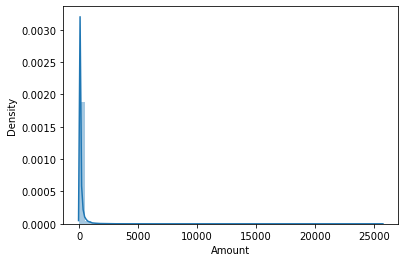

In [18]:
sns.distplot(a=data['Amount'])

In [19]:
# Skewness in the 'Amount' variable
data['Amount'].skew()

16.977724453761024

In [20]:
# for divide by zero values
data['Amount_log'] = np.log(data['Amount']+1)

C:\Users\DELL\Documents\ML\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Amount_log', ylabel='Density'>

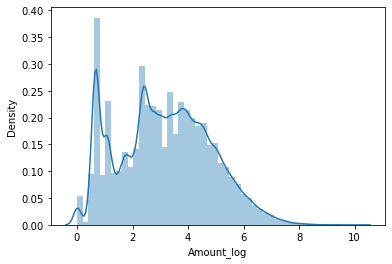

In [21]:
sns.distplot(a=data['Amount_log'])

In [22]:
# Skewness in the 'Amount' variable after log_transformation
data['Amount_log'].skew()

0.16270292774164014

#### Check if the dataset is imbalanced

<AxesSubplot:xlabel='Class', ylabel='count'>

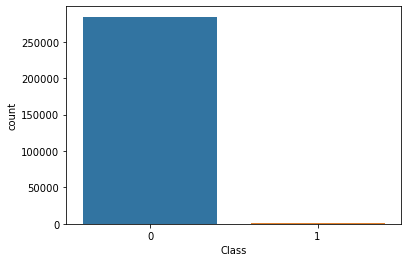

In [23]:
# Countplot showing the no. of records belonging to each class
sns.countplot(data=data,x='Class')

In [24]:
fraud = data[data['Class']==1]
no_fraud = data[data['Class']==0]

In [25]:
print(fraud.shape,no_fraud.shape)

(492, 32) (284315, 32)


In [26]:
# Percentage of records belonging to each class
print((fraud.shape[0]/data.shape[0])*100)
print((no_fraud.shape[0]/data.shape[0])*100)

0.1727485630620034
99.82725143693798


#### Split the data into input variables and target variable

In [27]:
X = data.drop(['Time','Class','Amount'],axis=1)
#X = data.drop('Class',axis=1)
y = data['Class']

In [28]:
print(X.shape,y.shape)

(284807, 29) (284807,)


In [29]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_log
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.014760
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1.305626
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.939276
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.824306
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.262539


#### Applying Undersampling 

In [30]:
#oversample = SMOTE(sampling_strategy=0.5)

In [31]:
#X, y = oversample.fit_resample(X, y)

In [32]:
#print(X.shape,y.shape)

In [34]:
# Number of records of each class after Oversampling
#print('Resampled dataset shape {}'.format(Counter(y)))

In [124]:
# fit and apply the transform
under = RandomUnderSampler(sampling_strategy=0.7)
X_res, y_res = under.fit_resample(X, y)

In [125]:
# Number of records of each class after Undersampling
print('Resampled dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 702, 1: 492})


In [126]:
print(X_res.shape,y_res.shape)

(1194, 29) (1194,)


##### Split data into train and test sets

In [128]:
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42,stratify=y_res)

##### Feature selection using ANOVA-f (because dtypes are numeric)

In [129]:
# define feature selection
fs = SelectKBest(score_func=f_classif, k=15)
# apply feature selection
fs.fit(X_train, y_train)

SelectKBest(k=15)

In [130]:
# Train and test sets with top 'k' relevant features
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [131]:
# ANOVA-f test scores of all features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 222.912078
Feature 1: 317.371496
Feature 2: 490.640471
Feature 3: 984.011284
Feature 4: 163.438682
Feature 5: 141.993213
Feature 6: 290.140350
Feature 7: 5.000489
Feature 8: 473.895441
Feature 9: 687.484187
Feature 10: 947.305560
Feature 11: 965.611710
Feature 12: 4.380959
Feature 13: 1354.705766
Feature 14: 4.901554
Feature 15: 587.731249
Feature 16: 502.949166
Feature 17: 283.648074
Feature 18: 77.105214
Feature 19: 29.464477
Feature 20: 15.044267
Feature 21: 1.787139
Feature 22: 0.105140
Feature 23: 2.856450
Feature 24: 0.971469
Feature 25: 7.744832
Feature 26: 2.774907
Feature 27: 11.786276
Feature 28: 7.628680


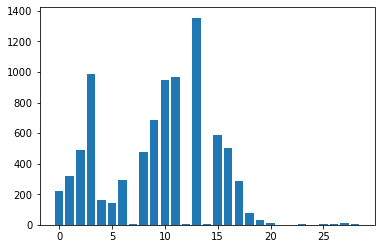

In [132]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [133]:
# Converting train and test sets with top 'k' relevant features into dataframes
X_train_fs = pd.DataFrame(X_train_fs)
X_test_fs = pd.DataFrame(X_test_fs)

In [134]:
X_train_fs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.288029,0.965681,-1.459495,1.921863,-1.912414,-1.130282,-2.814263,-0.695263,-3.465689,2.351619,-3.826705,-4.852867,-2.617361,-4.835558,-1.921752
1,1.945815,-0.463057,-0.191832,0.259412,-0.846752,-0.510429,-0.660094,0.934632,0.184373,0.867712,0.740077,0.239225,0.644673,-0.686973,0.127402
2,0.956234,-0.940620,-0.015190,-0.363923,-0.903784,-0.350327,-0.406154,-0.925934,0.168276,1.963815,0.255108,-1.085265,0.975051,1.415088,-1.240842
3,-0.679531,1.694971,-2.318976,0.059932,0.588015,-1.312202,0.068404,-0.247873,-1.450027,1.097850,-0.013865,-1.785815,1.146955,1.838583,2.106752
4,-5.005895,-4.256571,-0.139256,0.845446,2.584994,-1.398188,-0.727854,-0.026236,-1.017593,-1.508243,0.735672,0.218445,0.241200,-0.436236,0.225506


### Model building and evaluation

##### Logistic regression

In [135]:
lr = LogisticRegression()

In [136]:
# Fitting the model
lr.fit(X_train_fs,y_train)

LogisticRegression()

In [137]:
# Training score of the model
lr.score(X_train_fs,y_train)

0.9434554973821989

In [138]:
# Predictions on the test set
prediction = lr.predict(X_test_fs)

##### Evaluation

In [139]:
# Evaluation of the model on predictions
print(f1_score(y_test,prediction))

0.9411764705882354


In [146]:
scores = cross_val_score(lr,X_res,y_res,scoring = 'f1',cv=3,n_jobs=-1)
print(scores.mean())

0.9028534060058503


In [147]:
print(roc_auc_score(y_test,prediction))

0.9454334925459547


In [148]:
geometric_mean_score(y_test,prediction)

0.944240794937775

In [149]:
confusion_matrix(y_test,prediction)

array([[140,   1],
       [ 10,  88]], dtype=int64)

##### SVC

In [151]:
svclassifier = SVC(kernel='linear')

In [152]:
svclassifier.fit(X_train_fs, y_train)

SVC(kernel='linear')

In [153]:
svclassifier.score(X_train_fs, y_train)

0.9445026178010472

In [154]:
prediction = svclassifier.predict(X_test_fs)

##### Evaluation

In [155]:
print(f1_score(y_test,prediction))

0.935483870967742


In [156]:
scores = cross_val_score(svclassifier,X_res,y_res,scoring = 'f1',cv=3,n_jobs=-1)
print(scores.mean())

0.9051840853738562


In [157]:
print(roc_auc_score(y_test,prediction))

0.940331451729628


In [162]:
recall_score(y_test,prediction)

0.8877551020408163

In [158]:
confusion_matrix(y_test,prediction)

array([[140,   1],
       [ 11,  87]], dtype=int64)